In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
import itertools
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

In [2]:
#print(plt.style.available)
plt.style.use('seaborn-poster')

In [3]:
def get_data():
    ##Get data from the source that is used to generate map (based on WHO official data):
    ##https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR0oKIKJlc-zeNZGFBVEN0-O-58daoCDaKicXwC10cjFWgCZqTPgavseTfI#/bda7594740fd40299423467b48e9ecf6
    url_confirmed = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    url_deaths = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
    url_recovered = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"        
    for url, data_type in zip([url_confirmed, url_deaths, url_recovered], ["confirmed", "deaths", "recovered"]):
    
        r = requests.get(url)
        filename=data_type+".csv"
        f = open(filename,'wb')
        f.write(r.content)

In [4]:
get_data()

In [5]:
## prepare dataset
confirmed = pd.read_csv("confirmed.csv")
deaths = pd.read_csv("deaths.csv")
recovered = pd.read_csv("recovered.csv")

def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    #data=data.transpose().reset_index().rename(columns={'index':'Date'})
    #data['Date'] = pd.to_datetime(data['Date'])
    
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

inactive=deaths.add(recovered)

confirmed=confirmed.transpose().reset_index().rename(columns={'index':'Date'})
confirmed['Date'] = pd.to_datetime(confirmed['Date'])

inactive=inactive.transpose().reset_index().rename(columns={'index':'Date'})
inactive['Date'] = pd.to_datetime(inactive['Date'])

distance = inactive.copy()

In [6]:
#distance

In [7]:
# extract data for each country, divide by population and multiply by the value of per_num
dates=confirmed["Date"].values
dates_num = mdates.date2num(dates)
dates_start = np.min(dates_num)
dates_num = dates_num - dates_start

days_to_extrapolate=40
dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)

all_countries = inactive.columns[1:]

def get_day_closest_to_value(searched, country):
    df_sort = confirmed.iloc[(confirmed[country]-searched).abs().argsort()[:1]]
    index = df_sort[country].index.values[0]
    #print(confirmed.loc[index, "Date"])
    return index


for country in all_countries:
    distance[country] = inactive[country].apply(lambda x: get_day_closest_to_value(x,country) if x > 0 else np.nan)
    


In [8]:
distance = distance.reset_index()

In [9]:
distance = distance[all_countries].sub(distance['index'], axis=0)

In [10]:
distance

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,-26.0,-14.0,-16.0,-26.0,-28.0,-23.0,-26.0,-19.0,-26.0,-22.0,...,-32.0,-24.0,-17.0,-25.0,-32.0,-38.0,4.0,-18.0,-8.0,-28.0
103,-25.0,-14.0,-17.0,-27.0,-29.0,-24.0,-26.0,-19.0,-26.0,-22.0,...,-33.0,-25.0,-17.0,-26.0,-33.0,-36.0,3.0,-19.0,-9.0,-29.0
104,-25.0,-14.0,-17.0,-27.0,-30.0,-25.0,-27.0,-19.0,-26.0,-22.0,...,-34.0,-21.0,-17.0,-27.0,-33.0,-34.0,2.0,-5.0,-7.0,-30.0
105,-25.0,-14.0,-17.0,-28.0,-31.0,-26.0,-27.0,-20.0,-27.0,-22.0,...,-35.0,-20.0,-17.0,-23.0,-34.0,-34.0,1.0,-6.0,-6.0,-31.0


In [11]:
distance = distance[all_countries].multiply(-1, axis=0)

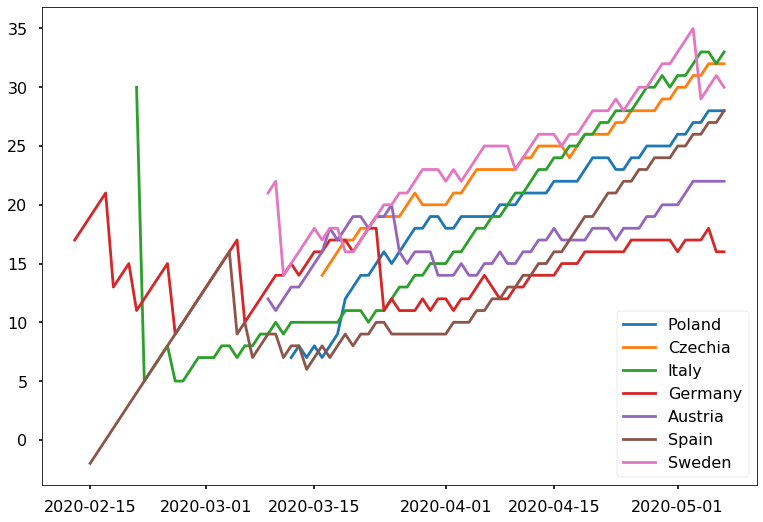

In [12]:
countries_to_plot=['Poland', 'Czechia', 'Italy', 'Germany', 'Austria', 'Spain', 'Sweden']

for country in countries_to_plot:
    plt.plot(dates, distance[country], label = country)
    plt. legend()

In [13]:
N=10
confirmed_derivative_ave = confirmed[all_countries].diff(periods=N)
inactive_derivative_ave = inactive[all_countries].diff(periods=N)

confirmed_derivative = confirmed[all_countries].diff(periods=1)
inactive_derivative = inactive[all_countries].diff(periods=1)


In [14]:
derivatives_ratio = confirmed_derivative.div(inactive_derivative)
derivatives_ratio_ave = confirmed_derivative_ave.div(inactive_derivative_ave)

77
230.2


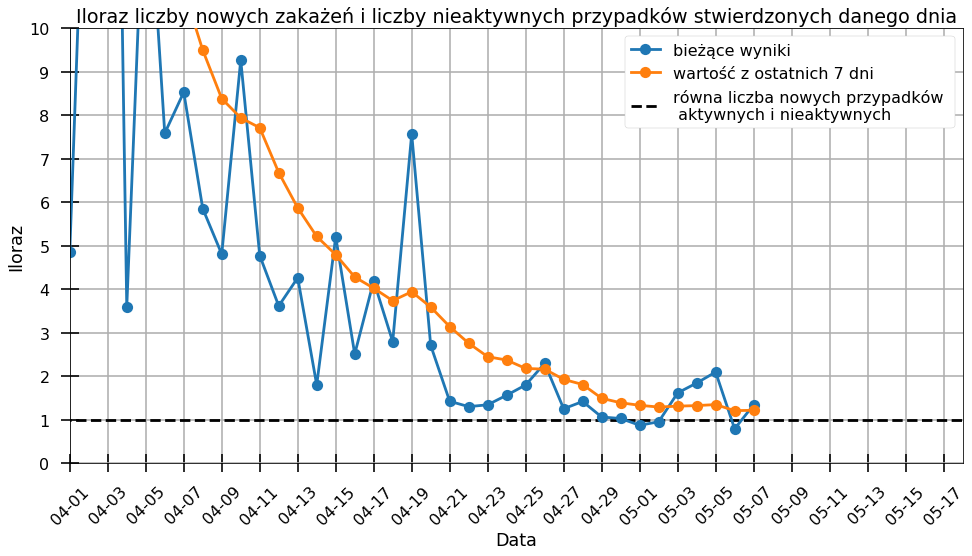

In [15]:
def exponent(x, a, b, c):
    return a * np.exp(b * (x-c))

countries_to_plot=['Poland']
rolling = derivatives_ratio.rolling(N, win_type ='triang').mean()

fig, axis = plt.subplots(1,1, figsize=(16, 8), )

x_dates = mdates.num2date(dates_num_extrapolate+dates_start)


for country in countries_to_plot:
    axis.plot(dates, derivatives_ratio[country], label = "bieżące wyniki", marker="o",)
    axis.plot(dates, derivatives_ratio_ave[country], label = "wartość z ostatnich 7 dni", marker="o", zorder=10)
    
    axis.hlines(1, x_dates[0], x_dates[-1], linestyles='--', label='równa liczba nowych przypadków \n aktywnych i nieaktywnych')
    
    y = derivatives_ratio_ave[country]
    y[y == np.inf] = 0
    
    fit_start=(np.nanargmax(y))+12
    print(fit_start)
    print(y[65])
    
    popt, pcov = curve_fit(exponent, dates_num[fit_start:], y[fit_start:], maxfev=10000)
    fit = exponent(dates_num_extrapolate[fit_start:], *popt)
    #axis.plot(mdates.num2date(dates_num_extrapolate[fit_start:]+dates_start), fit, label="dopasowanie zanik wykładniczy")
    
    fit_start=(np.nanargmax(y))+20
    0
    popt, pcov = curve_fit(exponent, dates_num[fit_start:], y[fit_start:], maxfev=10000)
    fit = exponent(dates_num_extrapolate[fit_start:], *popt)
    #axis.plot(mdates.num2date(dates_num_extrapolate[fit_start:]+dates_start), fit, label="dopasowanie zanik wykładniczy")
    
    
    
    
    tick_spacing=2
    axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    axis.xaxis.set_tick_params(rotation=45, direction="out")

    tick_spacing=1
    axis.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    date_form = DateFormatter("%m-%d")
    axis.xaxis.set_major_formatter(date_form)
    axis.tick_params(direction='inout', length=18, colors='k')  
    
    axis.grid(True)
    
    ## axes limits
    axis.set_xlim([datetime.date(2020, 4, 1), datetime.date.today() + datetime.timedelta(days=days_to_extrapolate-30)])# datetime.date(2020, 3, 15)])
    axis.legend()
    axis.set_ylim([-0,10])
    #axis.set_yscale("log")
    legend = axis.legend(frameon=1, facecolor='white', framealpha=1, fontsize=16, handlelength=1.8)#, loc='upper left')

    
axis.set(xlabel="Data",
       ylabel="Iloraz",
       title="Iloraz liczby nowych zakażeń i liczby nieaktywnych przypadków stwierdzonych danego dnia")    
plt.show()




In [16]:
print(derivatives_ratio[country][-10:])

97     1.417040
98     1.060302
99     1.025974
100    0.870229
101    0.950704
102    1.614213
103    1.841176
104    2.093596
105    0.788265
106    1.340611
Name: Poland, dtype: float64


In [17]:
dates_num[fit_start:]

array([ 85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
        96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.])

In [18]:
derivatives_ratio_ave["Poland"].values[-10:]

array([1.8075923 , 1.49088484, 1.38741022, 1.32937807, 1.28910334,
       1.31000412, 1.32229299, 1.34612106, 1.20672334, 1.21475473])